### Exploring Agglomerative Clustering & Comparting it to K-Means &DBSCAN 


In [ ]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics.cluster import silhouette_score
from adspy_shared_utilities import plot_labelled_scatter
import matplotlib.pyplot as plt

In [ ]:
# need version 1.4.1 to get read_pickle method to work
pd.__version__

'1.4.1'

In [ ]:
# get location from clean pickel file
cln_pkl_loc = Path('cleanweathersmall.pkl')
# load it onto df
df = pd.read_pickle(cln_pkl_loc)
# quick look at the df
df.sample(3)

,station,time,temp,dwpt,rhum,prcp,wdir,wspd,pres
2024203,KFFX0,2022-07-17 01:00:00,22.6,18.8,79.0,0.0,0.0,0.0,1015.0
2575315,KMCD0,2022-04-16 01:00:00,-2.2,-6.0,75.0,0.0,310.0,14.8,1011.0
3696651,UV7W2,2022-03-19 06:00:00,-0.1,-2.3,85.0,0.0,205.0,16.6,1013.0


### Apply Agglomerative Algorithm to create clusters

### Create clusters by grouping all stations by month and by hours based on datestamps

In [4]:
# loop thru all twelve months:
Agglomerative_list = [] # = pd.DataFrame()
for mth in range(1,13):
    # loop thru all 24 hours
    for hr in range(24):
        # query df based on month and time
        tmp_df = df.query(f'time.dt.hour == {hr} and time.dt.month == {mth}')
        # remove time variable from df
        tmp_df = tmp_df.loc[: , tmp_df.columns != 'time']
        # calculate mean of such datafrme
        tmp_df = tmp_df.groupby('station').mean()
        # drop null values
        tmp_df.dropna(inplace=True)
        # if we get a result, calculate Agglomerative clusters
        if not tmp_df.empty:
            # rescale the data to zero mean and unit variance
            scaler = StandardScaler()
            scaler.fit(tmp_df)
            X_scaled = scaler.transform(tmp_df)
            # apply Agglomerative clustering; start with known cluster count from DBSCAN, 5
            agg = AgglomerativeClustering(n_clusters = 5)
            # run the Agglomerative algorithm
            clusters = agg.fit_predict(X_scaled)
            # attach clusters to df
            tmp_df['Agglomerative_cluster'] = clusters
            # add month and hour as variables
            tmp_df['hr'], tmp_df['mth'] = hr, mth
            # calculate the silhouette score; only if they're not outliers
            tmp_df['silhouette_score'] = -1
            if set(clusters) != {-1}:
                tmp_df['silhouette_score'] = silhouette_score(X_scaled, clusters)                
            # collect all dfs
            Agglomerative_list.append(tmp_df)
            
# collect all Agglomerative dfs into one
Agglomerative_df = pd.concat(Agglomerative_list)
# reset the index; we can query the 'station' as a column much easier
Agglomerative_df.reset_index(inplace=True)

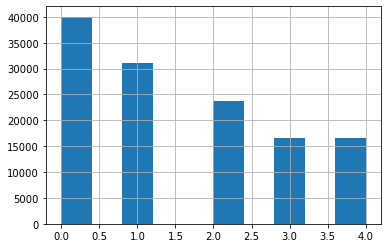

In [5]:
# quick distribution of the clusters; NOT as evenly as K-Means
# Agglomerative_df.groupby('Agglomerative_cluster').count()[['station']]
Agglomerative_df.Agglomerative_cluster.hist();

### Select Clusters Where AA Shows up

In [6]:
# list the clusters where KARB0 shows up; exclude the -1 (outliers)
AA_Clusters = Agglomerative_df.query('station == "KARB0"')['Agglomerative_cluster'].unique()
AA_Clusters

array([0, 1, 2, 3, 4])

In [7]:
# what stations make up these clusters?
AA_near_stations = Agglomerative_df.query('Agglomerative_cluster in @AA_Clusters and silhouette_score > 0')['station'].unique()
len(AA_near_stations), # PRETTY much the same as K-Means

(607,)

### Since all FIVE clusters contain all stations, let's filter those with the highest Silhouette scores

In [8]:
# sort the scores in descending order
top_Agg_scr = sorted(Agglomerative_df.query('Agglomerative_cluster in @AA_Clusters and silhouette_score > 0')['silhouette_score'].unique())[::-1]
# there are over 200 scores. The top [3] scores already produce over 500 matches (see cell below)!
top_Agg_scr = top_Agg_scr[0]
top_Agg_scr # Strikingly similar to K-Means

0.272721373580062

In [9]:
# see how many stations are with the highest score(s)
AA_top_stations = Agglomerative_df.query('Agglomerative_cluster in @AA_Clusters and silhouette_score >= @top_Agg_scr')['station'].unique()
len(AA_top_stations), # TWICE the number I got from K-Means :-(

(574,)

### Let's compare & filter stations based on combined K-Means & DBSCAN clusters

In [16]:
# EXTREMELY likely that Agglomerative contains all station that K-Means & DBSCAN have
# import df with clusters; let's compare these results for K-Means
DBS_Kmeans_Agg_df = pd.read_pickle('DBSCAN_KMeans_clusters.pkl')

In [17]:
# combine it with Agglomerative df
DBS_Kmeans_Agg_df['Agglomerative_cluster'], DBS_Kmeans_Agg_df['Agg_sil_cluster'] = Agglomerative_df['Agglomerative_cluster'], Agglomerative_df['silhouette_score']
DBS_Kmeans_Agg_df.head()

,station,temp,dwpt,rhum,prcp,wdir,wspd,pres,DBSCAN_cluster,hr,mth,silhouette_score,KMeans_cluster,KMeans_sil_cluster,Agglomerative_cluster,Agg_sil_cluster
0,0CNUO,-18.687097,-21.796774,76.483871,0.025806,213.032258,13.019355,1021.983871,0,0,1,-0.381491,1,0.224788,1,0.158762
1,0CO7B,-4.809677,-10.377419,66.193548,0.035484,198.935484,17.574194,1020.374194,3,0,1,-0.381491,2,0.224788,0,0.158762
2,0FV1F,-6.735484,-11.441935,71.451613,0.054839,203.580645,13.551613,1019.890323,1,0,1,-0.381491,2,0.224788,0,0.158762
3,1J1PJ,-10.874194,-15.000000,72.000000,0.016129,190.000000,15.258065,1018.496774,-1,0,1,-0.381491,4,0.224788,4,0.158762
4,1JWST,-15.935484,-18.141935,83.161290,0.190323,183.967742,5.967742,1019.154839,-1,0,1,-0.381491,0,0.224788,3,0.158762


In [18]:
# list the clusters where KARB0 shows up; exclude the -1 (outliers)
AA_KMeans_Clusters = DBS_Kmeans_Agg_df.query('station == "KARB0"')['KMeans_cluster'].unique()
AA_KMeans_Clusters
# sort the scores in descending order
top_KMeans_silh_scr = sorted(DBS_Kmeans_Agg_df.query('KMeans_cluster in @AA_KMeans_Clusters and KMeans_sil_cluster > 0')['KMeans_sil_cluster'].unique())[::-1]
top_KMeans_silh_scr = top_KMeans_silh_scr[0]
top_KMeans_silh_scr
# list the clusters where KARB0 shows up; exclude the -1 (outliers)
# ALSO, bring in ONLY those with the highest K-Means Silhouette scores
AA_Clusters = DBS_Kmeans_Agg_df.query('station == "KARB0" \
                            and DBSCAN_cluster != -1 \
                            and KMeans_sil_cluster >= @top_KMeans_silh_scr')['KMeans_cluster'].unique()

# what stations make up these clusters (for both clustering algorithms)?
AA_KMeans_near_stations = DBS_Kmeans_Agg_df.query('KMeans_cluster in @AA_KMeans_Clusters and KMeans_sil_cluster >= @top_KMeans_silh_scr')['station'].unique()
len(AA_KMeans_near_stations), AA_KMeans_near_stations

(573,
 array(['0CNUO', '0CO7B', '0FV1F', '1J1PJ', '1JWST', '20QWH', '21O3U',
        '2W8UZ', '3S56J', '4DUJO', '5RUZT', '6N2T2', '6URQB', '71140',
        '71147', '71148', '71170', '71172', '71261', '71270', '71273',
        '71283', '71291', '71292', '71298', '71299', '71301', '71303',
        '71307', '71352', '71368', '71433', '71435', '71438', '71439',
        '71441', '71449', '71460', '71461', '71462', '71464', '71465',
        '71468', '71527', '71538', '71559', '71560', '71564', '71573',
        '71579', '71582', '71623', '71631', '71632', '71633', '71634',
        '71637', '71642', '71655', '71660', '71667', '71704', '71730',
        '71733', '71738', '71739', '71747', '71748', '71750', '71751',
        '71767', '71831', '71832', '71834', '71840', '71849', '71850',
        '71851', '71962', '72013', '72014', '72019', '72034', '72420',
        '72428', '72516', '72520', '72521', '72524', '72525', '72526',
        '72530', '72531', '72532', '72533', '72534', '72535', '72536',


In [19]:
# check and see that DBSCAN  stations are on K-Means
DBSCAN_AA_Clusters = DBS_Kmeans_Agg_df.query('station == "KARB0" and DBSCAN_cluster != -1')['DBSCAN_cluster'].unique()
DBSCAN_AA_near_stations = DBS_Kmeans_Agg_df.query('DBSCAN_cluster in @DBSCAN_AA_Clusters')['station'].unique()
len(set(AA_near_stations).intersection(set(AA_KMeans_near_stations))), set(AA_near_stations).intersection(set(AA_KMeans_near_stations))

(573,
 {'0CNUO',
  '0CO7B',
  '0FV1F',
  '1J1PJ',
  '1JWST',
  '20QWH',
  '21O3U',
  '2W8UZ',
  '3S56J',
  '4DUJO',
  '5RUZT',
  '6N2T2',
  '6URQB',
  '71140',
  '71147',
  '71148',
  '71170',
  '71172',
  '71261',
  '71270',
  '71273',
  '71283',
  '71291',
  '71292',
  '71298',
  '71299',
  '71301',
  '71303',
  '71307',
  '71352',
  '71368',
  '71433',
  '71435',
  '71438',
  '71439',
  '71441',
  '71449',
  '71460',
  '71461',
  '71462',
  '71464',
  '71465',
  '71468',
  '71527',
  '71538',
  '71559',
  '71560',
  '71564',
  '71573',
  '71579',
  '71582',
  '71623',
  '71631',
  '71632',
  '71633',
  '71634',
  '71637',
  '71642',
  '71655',
  '71660',
  '71667',
  '71704',
  '71730',
  '71733',
  '71738',
  '71739',
  '71747',
  '71748',
  '71750',
  '71751',
  '71767',
  '71831',
  '71832',
  '71834',
  '71840',
  '71849',
  '71850',
  '71851',
  '71962',
  '72013',
  '72014',
  '72019',
  '72034',
  '72420',
  '72428',
  '72516',
  '72520',
  '72521',
  '72524',
  '72525',
  '7

In [20]:
# EXTREMELY likely that Agglomerative contains all station that K-Means & DBSCAN have
# import df with clusters; let's compare these results for K-Means
DBS_Kmeans_Agg_df.to_pickle('DBSCAN_KMeans_Agg_clusters.pkl')